In [1]:
import sys
import sqlite3 as sql
import importlib

from math import *;
from os.path import basename;

sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\myPy')  
sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\AblationSims')
sys.path.append('C:\\Users\\Vandiver\\Documents\\HiFU\\code\\BioHeatCpp\\PBHEswig\\x64')

import numpy as np
import geom
import matplotlib.image as image
import matplotlib.pyplot as plt
import importlib
import sonalleve
import transducers

import MRDataAnalysis
#from matplotlib.mlab import griddata

import matplotlib.transforms as mpl_trans

import scipy.interpolate as snt
import scipy.ndimage.filters as sflt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import nibabel
import visvis as vv
#os.chdir('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\AblationSims\\path_optimization\\')

%matplotlib inline
np.set_printoptions(precision=4, suppress=True, threshold=1300)

plt.rc('font', family='sans-serif', size=20)

In [62]:
importlib.reload(MRDataAnalysis)

<module 'MRDataAnalysis' from 'C:\\Users\\vchaplin\\Documents\\HiFU\\code\\myPy\\MRDataAnalysis.py'>

In [24]:
importlib.reload(transducers)

<module 'transducers' from 'C:\\Users\\vchaplin\\Documents\\HiFU\\code\\myPy\\transducers.py'>

In [58]:
file1="/Users/Vandiver/Data/sonalleve/HifuEggAg_20160211/scan10_TemperatureMappingCLEAR10_20160211.PAR"
#file2="/Users/Vandiver/Data/sonalleve/HifuEggAg_20160211/scan7_TemperatureMapping_20160217.PAR"
 
(tempdata1,complIm1,im1, dyntimes1)= MRDataAnalysis.read_TempScan(file1,MP_interleaved=False, phase_unwrap=1, pi_val=-0.2)
#(tempdata2,complIm2,im2, dyntimes2)= MRDataAnalysis.read_TempScan(file2,MP_interleaved=True, phase_unwrap=1, pi_val=-0.2)

aff1=im1.get_affine()
invaff1=np.linalg.inv(aff1)

RASsliceAxis=np.where( np.abs( np.abs( aff1.dot([0,0,1,1]  ) - aff1.dot([0,0,0,1]  ) )) > 0 )[0][0]

hifuAxisDimension = np.where( np.abs( np.abs( invaff1.dot([0,0,0,1]  ) - invaff1.dot([0,1,0,1]  ) )) > 0 )[0][0]

print("RASsliceAxis = ",RASsliceAxis)
print("hifuAxisDimension = ",hifuAxisDimension)

print(tempdata1.shape)
(junk,junk,nslc1,ndyn1)=tempdata1.shape

RASsliceAxis =  2
hifuAxisDimension =  1
(144, 144, 15, 10)


In [4]:
simToDataR = MRDataAnalysis.LPH_to_RAS().dot( MRDataAnalysis.Tpom_from_Orientation('Head First Supine') )

uRAS,focus=sonalleve.get_sonalleve_xdc_vecs(R=simToDataR, ret_focus=True)
unormalsRAS = sonalleve.get_sonalleve_xdc_normals(R=simToDataR)
uRAS-=focus
focus-=focus
uRASmm=1000.0*uRAS

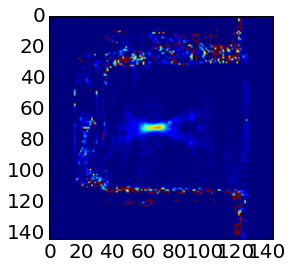

In [6]:
plt.imshow( (tempdata1[:,:,8,7]), vmin=0,vmax=30 )

In [41]:
im1.header.get_zooms()

(1.519, 1.519, 3.0, 0.024366)

In [5]:
db = "/Users/Vandiver/Data/sonalleve/sonalleve.db"
con = sql.connect(db)
con.row_factory = sql.Row

In [6]:
cur=con.execute("select * from data where file = ?", [basename(file1)] )

In [7]:
rw=cur.fetchone()

In [8]:
v0a,v0b,v1a,v1b,v2a,v2b=rw['start0'],rw['end0'],rw['start1'],rw['end1'],rw['start2'],rw['end2']
targetCenterVox_f=[(v0a+v0b)/2.0, (v1a+v1b)/2.0, (v2a+v2b)/2.0  ]
targetCenterRASmm=aff1[0:3,0:3].dot(targetCenterVox_f) +aff1[0:3,3]

u_RAS_offset = uRAS + targetCenterRASmm/1000.0

In [9]:
#simpntsR = np.linspace(-20,20,80) 
simpntsR = targetCenterRASmm[0:1]
simpntsA = np.linspace(-40,40,80) #HIFU axis negative direction
#simpntsS = np.linspace(-20,20,80) 
simpntsS = targetCenterRASmm[2:3]

In [10]:
NN = uRAS.shape[0]
rho=1020.0
c0=1540.0
k0 = 2*pi*1.2e6/(c0)
Prsim = transducers.calc_pressure_field_cuda(k0, u_RAS_offset, unormalsRAS, np.ones(NN)/NN,
                                             simpntsR*1e-3,simpntsA*1e-3,simpntsS*1e-3, 
                                             subsampN=60, subsampDiam=0.0033, ROC=0.14 )

In [13]:

Pr1d = transducers.calc_pressure_profile_cuda(k0, u_RAS_offset, unormalsRAS, np.ones(NN)/NN,
                                             np.ones_like(simpntsA)*targetCenterRASmm[0]*1e-3,
                                              simpntsA*1e-3,
                                              np.ones_like(simpntsA)*targetCenterRASmm[2]*1e-3, 
                                             subsampN=60, subsampDiam=0.0033, ROC=0.14)

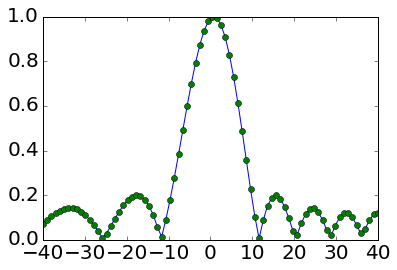

In [16]:
plt.plot(simpntsA, np.abs(Prsim[0,:,0]) )
plt.plot(simpntsA, np.abs(Pr1d),'o' )

In [283]:
fitVoxEdges0 = np.arange(v0a,v0b+2)
fitVoxEdges1 = np.arange(v1a,v1b+2)
fitVoxEdges2 = np.arange(v2a,v2b+2)

fitVox0=fitVoxEdges0[0:-1]
fitVox1=fitVoxEdges1[0:-1]
fitVox2=fitVoxEdges2[0:-1]

margin=[5,10,2]
voxstep=[0.5,0.25,0.25]
simVox0 = np.arange(v0a - margin[0], v0b+1.000+ margin[0], voxstep[0] )
simVox1 = np.arange(v1a - margin[1], v1b+1.000+ margin[1], voxstep[1])
simVox2 = np.arange(v2a - margin[2], v2b+1.000+ margin[2], voxstep[2])

simMesh0, simMesh1, simMesh2 = np.meshgrid(simVox0, simVox1, simVox2,indexing='ij')

#image coordinates are rectilinear and the affine does not apply any deformation. thus applying the affine is the
#same as a rotation and the 
simMeshR, simMeshA, simMeshS = geom.rotate_mesh_volume(aff1[0:3,0:3], simMesh0, simMesh1, simMesh2, translate=aff1[0:3,3])



In [130]:
simMeshR.shape

(35, 109, 33)

In [ ]:
np.tensordot()

In [64]:
Psim3d = transducers.calc_pressure_mesh3D_cuda(k0, u_RAS_offset, unormalsRAS, np.ones(NN)/NN,
                                             simMeshR*1e-3,simMeshA*1e-3,simMeshS*1e-3, 
                                             subsampN=10, subsampDiam=0.0033, ROC=0.14 )

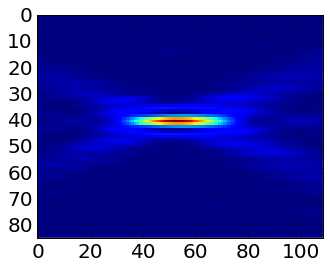

In [65]:
plt.imshow(np.abs(Psim3d[:,:,15])**2, interpolation='none')

In [119]:
aff1[0:3,0:3].dot(centerVox_f) +aff1[0:3,3]

array([-3.3605,  0.8225, -2.289 ])

In [90]:
tempdata1[v0a:v0b+1, v1a:v1b+1, v2a:v2b+1, 5].shape

(11, 7, 4)

In [76]:
tuple(map(lambda x: [x], range(4-1,-1,-1) ) )

([3], [2], [1], [0])

In [263]:
importlib.reload(imagemanip)

<module 'imagemanip' from 'C:\\Users\\vchaplin\\Documents\\HiFU\\code\\myPy\\imagemanip.py'>

In [219]:
import imagemanip

In [229]:
fitVox0=np.arange(65.0,71.0,1.0)
simVox0=np.arange(65.0,73.0,0.5)

In [284]:
f00=imagemanip.calc_bin2bin_AvgFilter(fitVoxEdges0, simVox0)

In [285]:
if00=imagemanip.calc_bin2bin_AvgFilter(simVox0, fitVoxEdges0)

In [286]:
if00.shape

(11, 41)

In [287]:
fitVox0

array([65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75])

In [261]:
simVox0

array([ 60. ,  60.5,  61. ,  61.5,  62. ,  62.5,  63. ,  63.5,  64. ,
        64.5,  65. ,  65.5,  66. ,  66.5,  67. ,  67.5,  68. ,  68.5,
        69. ,  69.5,  70. ,  70.5,  71. ,  71.5,  72. ,  72.5,  73. ,
        73.5,  74. ,  74.5,  75. ,  75.5,  76. ,  76.5,  77. ,  77.5,
        78. ,  78.5,  79. ,  79.5,  80. ,  80.5])

In [288]:
if00.dot(f00)

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

In [290]:
if00.dot(tt) - tempdata1[v0a:v0b+1,v1a,v2a,5] 

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [289]:
tt=f00.dot( tempdata1[v0a:v0b+1,v1a,v2a,5] )

In [291]:
np.sum(tempdata1[v0a:v0b+1,v1a,v2a,5]) - np.sum(tt)

0.0

In [295]:
simVox0.shape

(42,)

ValueError: x and y must have same first dimension

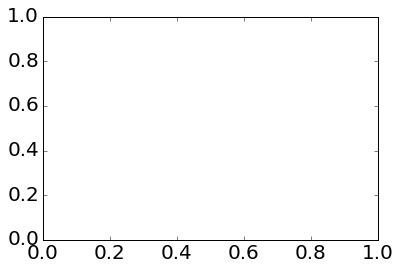

In [293]:
plt.plot( simVox0, tt,'.' )
plt.plot( fitVox0, if00.dot(tt),'.' )

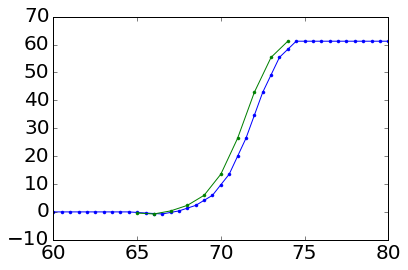

In [280]:
plt.plot( simVox0[0:-1], np.cumsum(tt),'.-' )
plt.plot( fitVox0[0:-1], np.cumsum(if00.dot(tt)),'.-' )

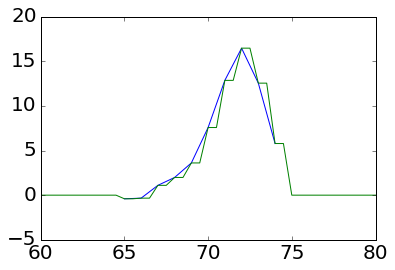

In [282]:
plt.plot( fitVox0[0:-1], tempdata1[v0a:v0b,v1a,v2a,5] )
plt.plot( simVox0[0:-1], 2*tt )